# ESTRATEGIA VALUE

## Autor: Lucía Saiz Lapique

__Examen__

__Gestión de Activos y Carteras__

__CUNEF__

Para esta estrategia, se utilizan tanto el valor de la empresa sobre el EBITDA como los dividendos a un año de numerosos activos que vemos en los datos importados a continuación, para obtener una valoración de los mismos.

Con este factor de riesgo queremos identificar aquellas acciones que son más baratas y aquellas que son más caras a partir de los ratios contables utilizados.

Construiremos un modelo alternative risk premium (alternative beta), neutral al mercado.

Esta estrategia realiza un ranking de todos los activos en función a las posiciones de cada uno a corto o largo plazo (la importancia de cada plazo depende del peso que le demos a cada una y será explicada más adelante). El objetivo no es solo optimizar las rentabilidades de las acciones seleccionadas, sino hacer pruebas a la hora de seleccionar una estrategia u otra. 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

Importamos los datos que se desean analizar para nuestra cartera.

In [24]:
datos = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Datos')
datos = datos.set_index('Name')
datos.head()

,Symbol,Price,Currency,Sector,Country,OPER_MARGIN,RETURN_ON_INV_CAPITAL,ROC_WACC_RATIO,OPERATING_ROIC,OPER_INC_TO_TOT_DEBT,...,PX_TO_BOOK_RATIO,PX_TO_CASH_FLOW,EPS_GROWTH,DVD_PAYOUT_RATIO,EQY_REC_CONS,TOT_ANALYST_REC,TOT_BUY_REC,TOT_SELL_REC,TWITTER_SENTIMENT,NEWS_SENTIMENT
Name,,,,,,,,,,,,,,,,,,,,,
L'OREAL,OR FP Equity,269.700,EUR,Cosmetics/Personal Care,FRANCE,17.745099,11.919607,1.772554,17.325215,1.836388,...,5.11651,24.2592,-4.267845,63.253283,2.967742,31,7,8,-0.175997,0.441251
VINCI SA,DG FP Equity,90.320,EUR,Engineering&Construction,FRANCE,11.180850,7.025344,1.417503,10.390774,0.168256,...,2.45154,6.70978,9.293680,51.901082,3.760000,25,14,4,-0.151347,-0.070688
BANCO BILBAO VIZCAYA ARGENTA,BBVA SQ Equity,3.527,EUR,Banks,SPAIN,29.234690,2.635223,2.318590,2.221896,NaN,...,0.478253,NaN,-35.080363,49.270218,3.093750,32,11,9,0.021949,-0.471481
BANCO SANTANDER SA,SAN SQ Equity,2.527,EUR,Banks,SPAIN,23.411659,2.868100,2.262225,1.843059,NaN,...,0.435722,NaN,-17.593246,58.667174,3.562500,32,15,5,0.004102,-0.468159
ASML HOLDING NV,ASML NA Equity,320.500,EUR,Semiconductors,NETHERLANDS,23.610829,17.030943,1.282539,18.505194,0.841185,...,10.892,42.7511,0.983607,38.866863,3.951220,41,24,4,0.311931,0.311327


In [25]:
datos.columns

Index(['Symbol', 'Price', 'Currency', 'Sector', 'Country', 'OPER_MARGIN',
       'RETURN_ON_INV_CAPITAL', 'ROC_WACC_RATIO', 'OPERATING_ROIC',
       'OPER_INC_TO_TOT_DEBT', 'CUR_MKT_CAP', 'PE_RATIO', 'PX_TO_BOOK_RATIO',
       'PX_TO_CASH_FLOW', 'EPS_GROWTH', 'DVD_PAYOUT_RATIO', 'EQY_REC_CONS',
       'TOT_ANALYST_REC', 'TOT_BUY_REC', 'TOT_SELL_REC', 'TWITTER_SENTIMENT',
       'NEWS_SENTIMENT'],
      dtype='object')

Importamos también, por separado, los datos históricos de cada activo.

In [26]:
historicos = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Precios acciones')
historicos['Date'] = pd.to_datetime(historicos['Date'], format="%Y-%m-%d")
historicos = historicos.set_index('Date')
observacion = historicos.index >= dt.datetime(2015, 4, 30)
historicos = historicos[(observacion)]
historicos.head()

,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SA,AIR LIQUIDE SA,AXA SA,...,MERCK & CO. INC.,INTEL CORP.1,RAYTHEON TECHNOLOGIES CORP,VERIZON COMMUNICATIONS INC,COCA-COLA CO/THE,CISCO SYSTEMS INC.1,EXXON MOBIL CORP,WALGREENS BOOTS ALLIANCE INC.1,PFIZER INC,DOW INC
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,170.45,54.82,9.000,6.6449,96.71,25.655,13.640,48.485,94.0205,22.615,...,59.56,32.55,67.091,50.44,40.56,28.83,87.37,82.93,33.93,NaN
2015-05-01,170.45,54.82,9.000,6.6449,96.71,25.655,13.640,48.485,94.0205,22.615,...,59.86,33.42,68.088,50.41,40.91,29.13,88.85,83.46,34.08,NaN
2015-05-04,173.35,54.60,9.040,6.6380,96.78,25.440,13.765,48.130,95.4695,22.735,...,60.64,33.43,68.684,50.52,40.96,29.17,89.11,84.13,34.32,NaN
2015-05-05,166.70,53.76,8.825,6.4128,94.75,25.190,13.515,47.675,93.4168,22.275,...,60.49,32.64,67.870,50.09,40.75,28.89,88.61,83.14,34.12,NaN
2015-05-06,167.75,53.30,8.949,6.4816,93.67,25.080,13.520,47.845,93.9803,22.540,...,60.26,32.22,67.876,49.64,40.66,28.97,88.19,83.10,33.46,NaN


In [27]:
historicos.columns

Index(['L'OREAL', 'VINCI SA', 'BANCO BILBAO VIZCAYA ARGENTA',
       'BANCO SANTANDER SA', 'ASML HOLDING NV', 'KONINKLIJKE PHILIPS NV',
       'TELEFONICA SA', 'TOTAL SA', 'AIR LIQUIDE SA', 'AXA SA',
       ...
       'MERCK & CO. INC.', 'INTEL CORP.1', 'RAYTHEON TECHNOLOGIES CORP',
       'VERIZON COMMUNICATIONS INC', 'COCA-COLA CO/THE', 'CISCO SYSTEMS INC.1',
       'EXXON MOBIL CORP', 'WALGREENS BOOTS ALLIANCE INC.1', 'PFIZER INC',
       'DOW INC'],
      dtype='object', length=218)

Importamos también los datos del índice MXWD, que incluye los mercados emergentes y desarrollados, para comparar con este el comportamiento de la estrategia.

In [28]:
indice = pd.read_excel('datos_examen2.xlsx', sheet_name = 'Precios Index')
indice['Date'] = pd.to_datetime(indice['Date'], format="%Y-%m-%d")
indice = indice.set_index('Date')
observacion = indice.index >= dt.datetime(2015, 4, 30)
indice = indice[(observacion)]
indice.head()

,Euro Stoxx 50 Pr,IBEX 35 INDEX,DOW JONES INDUS. AVG,MSCI WORLD,NASDAQ COMPOSITE INDEX,S&P 500 INDEX,NIKKEI 225,FTSE 100 INDEX
Date,,,,,,,,
2015-04-30,3615.59,11385.0,17840.52,1778.40,4941.424,2085.51,19520.01,6960.63
2015-05-01,3615.59,11385.0,18024.06,1787.40,5005.391,2108.29,19531.63,6985.95
2015-05-04,3632.94,11429.1,18070.40,1790.83,5016.929,2114.49,19531.63,6985.95
2015-05-05,3546.56,11115.6,17928.20,1773.42,4939.327,2089.46,19531.63,6927.58
2015-05-06,3558.03,11163.6,17841.98,1772.82,4919.645,2080.15,19531.63,6933.74


A falta de los ratios contables que nos gustaría utilizar (EBITDA y dividendos a un año) para crear el ranking y los pesos ya que, en esta estrategia, y debido a que los ratios que se habían seleccionado tienen muchos valores nulos, se decide seleccionar el ROC_WACC_RATIO y el OPERATING_ROIC para calcular el valor de la empresa. Para ello, creamos un nuevo dataframe que será utilizado de ahora en adelante como los datos originales.

In [29]:
cuenta = datos.Symbol.count()
value = datos[['ROC_WACC_RATIO', 'OPERATING_ROIC']]
value.index = datos.index
value.isna().sum()

ROC_WACC_RATIO    0
OPERATING_ROIC    4
dtype: int64

In [30]:
ranking = value.rank(ascending=False) 
ranking.head()

,ROC_WACC_RATIO,OPERATING_ROIC
Name,,
L'OREAL,79.0,69.0
VINCI SA,113.0,98.0
BANCO BILBAO VIZCAYA ARGENTA,58.5,166.5
BANCO SANTANDER SA,61.5,171.5
ASML HOLDING NV,120.5,64.5


Seleccionamos unos pesos para el largo y corto plazo y se lo aplicamos a cada variable en función del ranking anterior.

In [31]:
corto = 50.0
largo = 50.0
peso_corto = -2
peso_largo = 2

In [32]:
lista = []
for i in ranking['ROC_WACC_RATIO']:
    m = []
    if i <= largo: 
        pesos = peso_largo/largo
        m.append(pesos)
    elif i >= (cuenta + 1 - corto): 
        pesos = peso_corto/corto
        m.append(pesos)
    else:
        pesos = 0
        m.append(pesos)
    lista.extend(m)
    weights = pd.DataFrame(lista, columns = ['ROC_WACC_RATIO'])

In [33]:
lista2 = []
for i in ranking['OPERATING_ROIC']:
    m = []
    if i <= largo: 
        pesos = peso_largo/largo
        m.append(pesos)
    elif i >= (cuenta + 1 - corto): 
        pesos = peso_corto/corto
        m.append(pesos)
    else:
        pesos = 0
        m.append(pesos)
    lista2.extend(m)
    weights2 = pd.DataFrame(lista2, columns = ['OPERATING_ROIC'])

Juntando los pesos de cada variable, obtenemos los pesos finales y añadimos una columna con el peso total de cada activo en base a su horizonte temporal.

In [34]:
weights['OPERATING_ROIC'] = weights2['OPERATING_ROIC']
weights['Name'] = datos.index
weights = weights.set_index('Name')
weights.head()

,ROC_WACC_RATIO,OPERATING_ROIC
Name,,
L'OREAL,0.0,0.00
VINCI SA,0.0,0.00
BANCO BILBAO VIZCAYA ARGENTA,0.0,0.00
BANCO SANTANDER SA,0.0,-0.04
ASML HOLDING NV,0.0,0.00


Se da más importancia al EBITDA tras comprobar que así se obtienen mejores resultados. Esto puede deberse a que permite analizar objetivamente la capacidad productiva de una empresa y por lo tanto una información más objetiva de la valoración y calidad de un activo ya que excluye la aleatoriedad en la dotación de provisiones y anula el impacto de los impuestos en los resultados.

In [35]:
imp = [0.5, 0.5]
sum(imp)

1.0

In [36]:
weights['Total'] = (imp*weights).sum(axis=1)
weights.head()

,ROC_WACC_RATIO,OPERATING_ROIC,Total
Name,,,
L'OREAL,0.0,0.00,0.00
VINCI SA,0.0,0.00,0.00
BANCO BILBAO VIZCAYA ARGENTA,0.0,0.00,0.00
BANCO SANTANDER SA,0.0,-0.04,-0.02
ASML HOLDING NV,0.0,0.00,0.00


Calculamos a continuación los resultados preliminares, teniendo en cuenta las rentabilidades originales de cada activo y el peso otorgado en cada plazo. 

In [37]:
resultados_peliminares = (weights * value).sum()
resultados_peliminares

OPERATING_ROIC    60.286015
ROC_WACC_RATIO     9.673847
Total              0.000000
dtype: float64

## Datos finales de la estrategia

Para la parte final de este estudio, debemos tener en cuenta los datos históricos de cada activo importados al principio del análisis. Estimamos el cambio de porcentaje de cada activo para obtener las renntabilidades diarias de cada una y así obtener los datos finales con los que generaremos la cartera óptima.

In [38]:
historicos = historicos.dropna(axis = 1)

In [39]:
df = historicos.pct_change().dropna()
df.head()

,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SA,AIR LIQUIDE SA,AXA SA,...,AMERICAN EXPRESS CO,MERCK & CO. INC.,INTEL CORP.1,RAYTHEON TECHNOLOGIES CORP,VERIZON COMMUNICATIONS INC,COCA-COLA CO/THE,CISCO SYSTEMS INC.1,EXXON MOBIL CORP,WALGREENS BOOTS ALLIANCE INC.1,PFIZER INC
Date,,,,,,,,,,,,,,,,,,,,,
2015-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002970,0.005037,0.026728,0.014860,-0.000595,0.008629,0.010406,0.016939,0.006391,0.004421
2015-05-04,0.017014,-0.004013,0.004444,-0.001038,0.000724,-0.008380,0.009164,-0.007322,0.015412,0.005306,...,0.007724,0.013030,0.000299,0.008753,0.002182,0.001222,0.001373,0.002926,0.008028,0.007042
2015-05-05,-0.038362,-0.015385,-0.023783,-0.033926,-0.020975,-0.009827,-0.018162,-0.009454,-0.021501,-0.020233,...,-0.005621,-0.002474,-0.023631,-0.011851,-0.008511,-0.005127,-0.009599,-0.005611,-0.011768,-0.005828
2015-05-06,0.006299,-0.008557,0.014051,0.010729,-0.011398,-0.004367,0.000370,0.003566,0.006032,0.011897,...,0.000128,-0.003802,-0.012868,0.000088,-0.008984,-0.002209,0.002769,-0.004740,-0.000481,-0.019343
2015-05-07,0.005067,-0.010319,0.005699,0.002129,0.002028,-0.010167,-0.003698,-0.022573,-0.003855,0.028394,...,0.007450,0.000664,0.000776,0.008339,0.001813,0.000984,-0.005696,-0.006690,0.013598,0.003586


In [40]:
def ratios(rentabilidades, weights):
    '''
        returns = dataframe que contiene las rentabilidades diarias de los activos
        weights = pesos de los activos para cada uno de los periodos de tiempo y en total
        -----------------------------------------------------------------------------------
        final = resultado de la estrategia
    '''
    
    # genero los resultados como un indice de base 100
    resultados = [100]
    
    # cojo los pesos totales de la matriz de pesos
    pesos = weights.iloc[:,-1]
    
    # voy calculado los resultados como el anterior mas 1 por la rentabilidad que se obtienen diariamente de las
    # distintas acciones y sus pesos
    for i in range(1, len(rentabilidades)):
        
        value = resultados[i-1] * (1 + (rentabilidades.iloc[i] * pesos).sum())
        
        resultados.append(value)
    
    # meto en un dataframe para devovler el resultado final y asigno las fechas coo indice
    final = pd.DataFrame(resultados, columns=['Value'])  
    final.set_index(rentabilidades.index, inplace=True)
        
    return final

En el dataframe a continuación, podemos observar el resultado de esta estrategia y la graficamos a continuación. Gráficamente, y en comparación con el índice MXWD, se observa que se ha conseguido obtener una estrategia neutral al mercado.

In [41]:
final = ratios(df, weights)
final

,Value
Date,
2015-05-01,100.000000
2015-05-04,99.182769
2015-05-05,99.368421
2015-05-06,98.272281
2015-05-07,98.173976
...,...
2020-06-01,437.309819
2020-06-02,427.611768
2020-06-03,408.623446


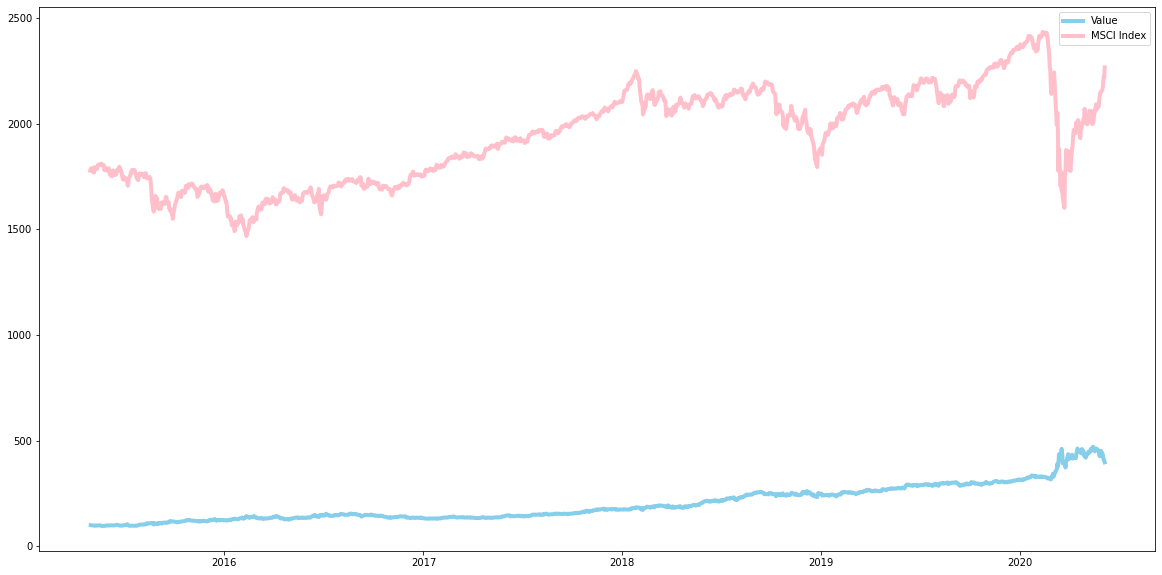

In [42]:
plt.figure(figsize=(20,10))
plt.plot(final.index, final['Value'], marker='', markerfacecolor='blue', markersize=12, color='skyblue', 
         linewidth=4, label ='Value')
plt.plot(indice.index, indice['MSCI WORLD'], marker='', markerfacecolor='blue', markersize=12, color='pink', 
         linewidth=4, label ='MSCI Index')
plt.legend()

Podemos concluir que la selección de pesos para los datos en cuestión es correcta (al aplicar el inverso, es decir, mayor peso al corto que al largo, los resultados eran peores, había más volatilidad). Esto se debe a que se cree que a futuro lo van a hacer mejor que aquellas acciones que tienen ahora una valoración más alta.

In [43]:
final.to_csv('Estrategia_Value_final.csv')